In [70]:
import os, glob
import thinkdsp
import thinkplot
import pickle
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import signalprocessing as sigp
import soundmfccparams as smfccp
import plotutilities as pltut

from graphviz import Source
from scipy.io.wavfile import write
from IPython.display import SVG
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, classification_report
from mlxtend.plotting import plot_decision_regions

In [2]:
# Path for signal/noise packs
signalPath = r"/home/vaclav/Desktop/Diploma/Clean Signals/ETHALON_SIGNAL"
noisePath = r"/home/vaclav/Desktop/Diploma/Clean Signals/ETHALON_NOISE"

In [3]:
## This is signal data extracting
signalMaxAmp = sigp.calculate_mean_amplitude_list(signalPath)
signalMaxAmpSplit = sigp.split_calculate_mean_amplitude_list(signalPath)
signalSco = sigp.calculate_SCO_amplitude_list(signalPath)
signalCentroid = sigp.calculate_CENTROID_list(signalPath)
signalSpread = sigp.calculate_SPREAD_list(signalPath)
signalFlatness = sigp.calculate_FLATNESS_list(signalPath)
# Extracting MFCC params (in Dataframe)
signalMfcc = smfccp.compute_mfcc(signalPath)

## This is noise data extracting
noiseMaxAmp = sigp.calculate_mean_amplitude_list(noisePath)
noiseMaxAmpSplit = sigp.split_calculate_mean_amplitude_list(noisePath)
noiseSco = sigp.calculate_SCO_amplitude_list(noisePath)
noiseCentroid = sigp.calculate_CENTROID_list(noisePath)
noiseSpread = sigp.calculate_SPREAD_list(noisePath)
noiseFlatness = sigp.calculate_FLATNESS_list(noisePath)
# Extracting MFCC params (in Dataframe)
noiseMfcc = smfccp.compute_mfcc(noisePath)

/home/vaclav/Desktop/Diploma/Notebooks/Classifier/signalprocessing.py:339: RuntimeWarning: divide by zero encountered in log
  return (np.exp((1 / length) * np.sum(np.log(magnitudes)))) / ((1 / length) * np.sum(magnitudes))


In [4]:
# Signal splitted amps
sigLst1 = [item[0] for item in signalMaxAmpSplit]
sigLst2 = [item[1] for item in signalMaxAmpSplit]
sigLst3 = [item[2] for item in signalMaxAmpSplit]
sigLst4 = [item[3] for item in signalMaxAmpSplit]

# Noise splitted amps
noiseLst1 = [item[0] for item in noiseMaxAmpSplit]
noiseLst2 = [item[1] for item in noiseMaxAmpSplit]
noiseLst3 = [item[2] for item in noiseMaxAmpSplit]
noiseLst4 = [item[3] for item in noiseMaxAmpSplit]

In [5]:
signalDataFrame = {'Total MaxAmp': signalMaxAmp, 'Split MaxAmp 1': sigLst1, 'Split MaxAmp 2': sigLst2, 'Split MaxAmp 3': sigLst3, 'Split MaxAmp 4': sigLst4, 'SCO': signalSco, 'Centroid': signalCentroid, 'Spread': signalSpread, 'Flatness': signalFlatness}
signalDataFrame = pd.DataFrame(data=signalDataFrame)
signalDataFrame.head()

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Centroid,Spread,Flatness
0,150491.537060,81973.574809,74724.705839,70135.186372,71275.026723,4768.996440,3178.265733,4.567400e+06,0.003763
1,82042.583804,32661.802768,41841.660856,44661.436320,39588.490420,1772.640815,2037.383653,4.821699e+06,0.004385
2,89231.836813,47440.002631,46963.024971,46181.307541,35778.529911,1867.283805,1966.114572,4.505704e+06,0.004202
3,85986.484422,43968.692152,43148.724241,39989.575746,38523.098552,1826.254177,2090.248768,5.341053e+06,0.004395
4,265757.244039,7634.898074,82612.244272,169295.802777,176952.319908,4826.593254,6255.840716,2.338890e+06,0.002094


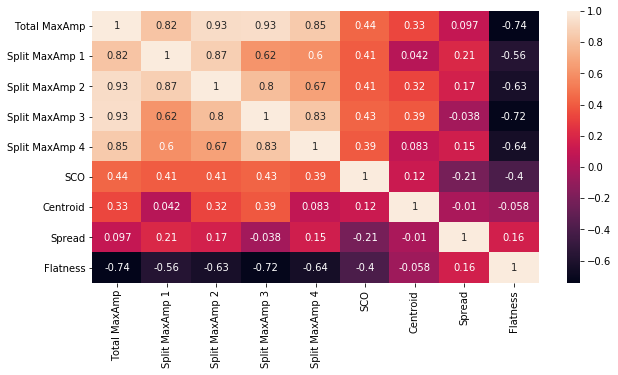

In [6]:
signalCorrMatrix = signalDataFrame.corr()
sn.heatmap(signalCorrMatrix, annot=True)

In [7]:
noiseDataFrame = {'Total MaxAmp': noiseMaxAmp, 'Split MaxAmp 1': noiseLst1, 'Split MaxAmp 2': noiseLst2, 'Split MaxAmp 3': noiseLst3, 'Split MaxAmp 4': noiseLst4, 'SCO': noiseSco, 'Centroid': noiseCentroid, 'Spread': noiseSpread, 'Flatness': noiseFlatness}
noiseDataFrame = pd.DataFrame(data=noiseDataFrame)
noiseDataFrame.head()

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Centroid,Spread,Flatness
0,58572.629848,12712.880668,51331.128619,13430.951514,13240.955752,698.882228,2548.586441,3.134702e+06,0.005459
1,84276.213591,43996.311645,35272.668624,36649.247568,49530.621587,1120.912389,2812.977884,5.389564e+06,0.005038
2,49003.089999,21320.580540,26510.360424,28879.748500,18536.076332,678.173577,2300.508560,2.858825e+06,0.005720
3,56074.745257,7221.676033,49630.376349,23879.049988,6358.469845,1000.198349,1865.417237,3.021044e+06,0.005134
4,55660.436938,2299.309245,8940.250692,46460.130380,29368.825568,1690.550653,1298.239441,3.019843e+06,0.004173


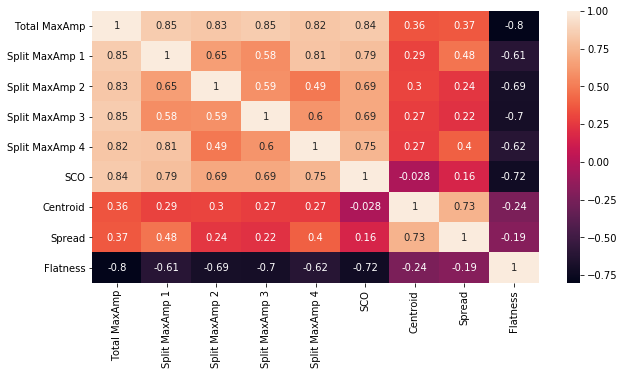

In [8]:
noiseCorrMatrix = noiseDataFrame.corr()
sn.heatmap(noiseCorrMatrix, annot=True)

In [9]:
# Append MFCC
signalDataFrame = pd.concat([signalDataFrame,signalMfcc], axis=1)
noiseDataFrame = pd.concat([noiseDataFrame,noiseMfcc], axis=1)

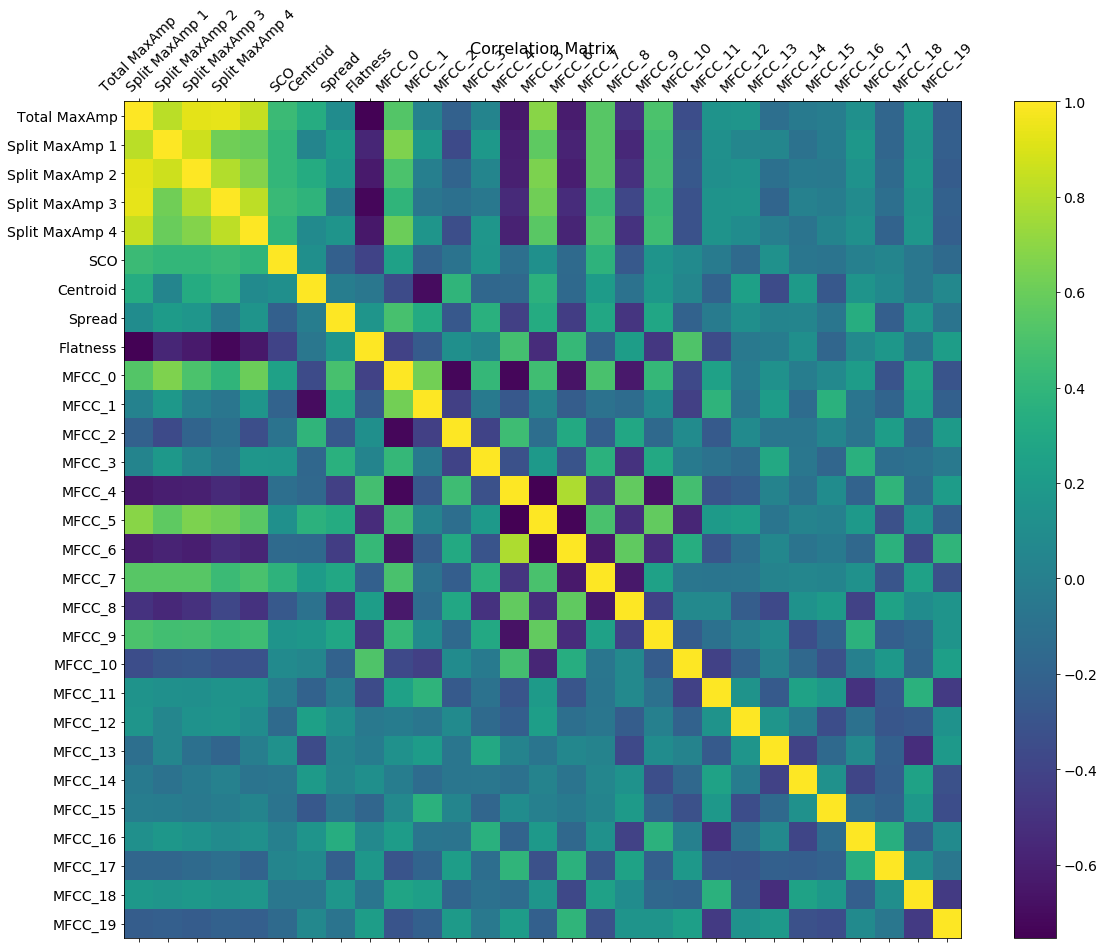

In [11]:
sigp.corr_matrix(signalDataFrame)

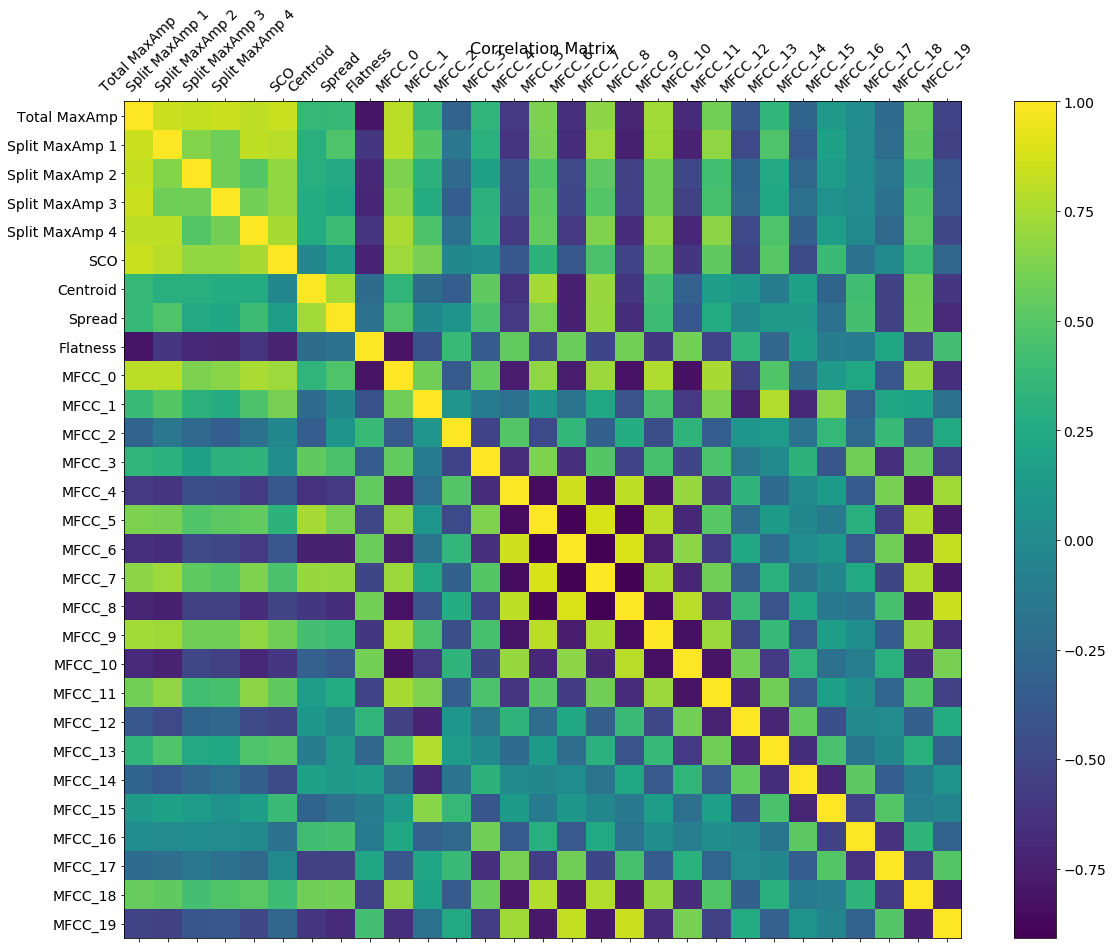

In [12]:
sigp.corr_matrix(noiseDataFrame)

In [13]:
# Using PCA to reduce components
#signalDataFrame = smfccp.pca_dataframe(signalDataFrame, 15)
#noiseDataFrame = smfccp.pca_dataframe(noiseDataFrame, 15)

In [14]:
#rng = range(0, int((len(list(signalDataFrame))-1)/2)+1)

#new_cols = ['type_' + str(i) for i in rng] + ['expt_' + str(i) for i in rng]

# ensure the length of the new columns list is equal to the length of df's columns
#signalDataFrame.columns = new_cols[:len(list(signalDataFrame))]
signalDataFrame

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Centroid,Spread,Flatness,MFCC_0,...,MFCC_10,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19
0,150491.537060,81973.574809,74724.705839,70135.186372,71275.026723,4768.996440,3178.265733,4.567400e+06,0.003763,-233.718796,...,-4.458062,1.067613,0.516805,7.727972,6.373898,-3.611062,14.580167,-0.361103,1.332859,-1.833363
1,82042.583804,32661.802768,41841.660856,44661.436320,39588.490420,1772.640815,2037.383653,4.821699e+06,0.004385,-301.328247,...,-14.146482,8.015750,0.375979,5.550191,7.088860,2.664846,9.060751,0.021489,5.768086,-3.603709
2,89231.836813,47440.002631,46963.024971,46181.307541,35778.529911,1867.283805,1966.114572,4.505704e+06,0.004202,-287.352295,...,-13.892034,9.431018,-2.065030,5.973203,8.321308,3.307363,8.581530,-2.927097,8.331109,-5.322766
3,85986.484422,43968.692152,43148.724241,39989.575746,38523.098552,1826.254177,2090.248768,5.341053e+06,0.004395,-300.564606,...,-16.257206,10.635303,-1.006228,8.676380,6.649755,2.188552,8.476087,-1.288104,7.784525,-5.613897
4,265757.244039,7634.898074,82612.244272,169295.802777,176952.319908,4826.593254,6255.840716,2.338890e+06,0.002094,-358.741730,...,-12.395898,6.572901,3.467196,2.015535,9.064105,-0.054644,9.150679,-3.157119,7.528465,-6.519304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,92513.363268,53570.047988,47299.770953,40433.846955,39342.743850,4301.132151,2733.229751,4.195326e+06,0.004597,-282.427612,...,-3.843441,6.859174,-2.606430,0.789813,14.929559,-1.013988,5.501278,-0.445138,12.274665,-9.896340
310,67181.444955,14627.469452,26219.766105,46250.275357,19855.269059,1794.981240,5287.803693,4.552231e+06,0.005029,-424.385040,...,-7.503268,1.503623,6.820916,-0.749205,10.613829,-0.397060,9.767618,-1.978881,7.251991,-2.918085
311,157098.324949,72840.651655,88111.439125,73822.497500,69795.218661,3141.175194,2191.986406,4.202690e+06,0.003165,-238.226517,...,-13.287461,8.027717,-1.288218,11.200619,6.972423,1.955083,2.686978,-5.980018,7.731324,-0.072837
312,40048.798352,5786.449537,31604.378978,24981.913354,8106.505168,2937.193897,3087.794786,3.122893e+06,0.005387,-431.239258,...,7.363627,-2.886717,6.239301,14.529841,0.715401,-3.349525,7.521462,2.872073,-6.620605,2.481946


In [15]:
#rng = range(0, int((len(list(noiseDataFrame))-1)/2)+1)

#new_cols = ['type_' + str(i) for i in rng] + ['expt_' + str(i) for i in rng]

# ensure the length of the new columns list is equal to the length of df's columns
#noiseDataFrame.columns = new_cols[:len(list(noiseDataFrame))]
noiseDataFrame

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Centroid,Spread,Flatness,MFCC_0,...,MFCC_10,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19
0,58572.629848,12712.880668,51331.128619,13430.951514,13240.955752,698.882228,2548.586441,3.134702e+06,0.005459,-389.945923,...,-13.017824,5.814240,-4.908351,6.511048,5.945688,5.107234,10.404021,-0.300071,7.658782,-4.628345
1,84276.213591,43996.311645,35272.668624,36649.247568,49530.621587,1120.912389,2812.977884,5.389564e+06,0.005038,-302.475464,...,-13.529956,7.614180,0.576080,6.227180,7.322908,1.919086,11.002797,-3.847258,10.830333,-9.096796
2,49003.089999,21320.580540,26510.360424,28879.748500,18536.076332,678.173577,2300.508560,2.858825e+06,0.005720,-374.232574,...,-15.363314,2.465794,2.937236,4.740872,7.716486,1.514369,7.957967,-3.611988,8.380780,-3.083670
3,56074.745257,7221.676033,49630.376349,23879.049988,6358.469845,1000.198349,1865.417237,3.021044e+06,0.005134,-433.223419,...,-6.178546,3.295416,4.865382,2.036165,9.009554,0.806819,9.648679,-1.223142,6.161716,-2.573241
4,55660.436938,2299.309245,8940.250692,46460.130380,29368.825568,1690.550653,1298.239441,3.019843e+06,0.004173,-438.554047,...,-8.884585,6.534148,0.447894,6.931505,6.683308,3.135692,7.220325,-0.692991,6.260170,-3.643665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,75711.499717,17418.042870,68947.880431,20773.443836,11354.554567,833.333211,2732.141246,4.288213e+06,0.005189,-402.805389,...,-10.434360,4.722930,4.179940,-0.432659,12.539351,-3.583985,12.889967,-4.133275,8.145557,-4.148302
310,193309.112425,95744.345481,95894.469352,97896.223007,97550.041513,2457.200364,2703.043271,5.006780e+06,0.003293,-205.159286,...,-16.626528,10.245478,-0.494975,3.698003,8.529514,-1.108651,11.290883,-3.575428,11.815619,-7.278941
311,75311.504988,14578.851503,12459.810816,70842.195601,14867.544036,942.370530,2548.960259,4.134718e+06,0.005146,-404.515930,...,-10.686538,3.064195,6.026714,0.056822,10.853155,-0.873472,9.972828,-2.669231,7.909886,-4.711977
312,88012.740509,32533.228875,45537.516639,21184.475140,62455.300276,1097.668204,2652.338549,4.502521e+06,0.004857,-335.694580,...,-10.850432,5.133152,5.048335,-0.526190,10.644738,-1.178085,10.416477,-2.384842,8.018136,-4.467659


In [16]:
# 1-es pack for final Dataframe (signals)
ones = {'Flag': np.ones(len(signalMaxAmp))}
onesFlag = pd.DataFrame(data=ones)

# 0-es pack for final Dataframe (noises)
zeroes = {'Flag': np.zeros(len(noiseMaxAmp))}
zeroesFlag = pd.DataFrame(data=zeroes)

# Adding "Flag" fields
signalDataFrame = signalDataFrame.assign(Flag=onesFlag['Flag'])
noiseDataFrame = noiseDataFrame.assign(Flag=zeroesFlag['Flag'])

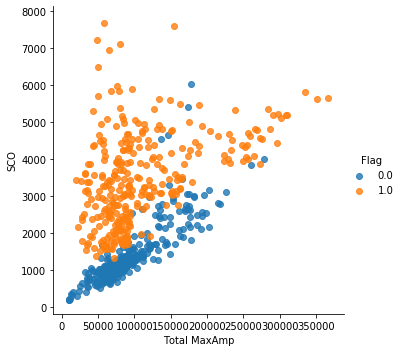

In [17]:
# Uniting signals & noises data in one Dataframe
learningDataframe = pd.merge(signalDataFrame, noiseDataFrame, how='outer')

# Visualizing the data (1 - signal, 0 - noise)
sn.lmplot('Total MaxAmp', 'SCO', data=learningDataframe, hue="Flag", fit_reg=False)
#sn.lmplot('type_0', 'type_2', data=learningDataframe, hue="Flag", fit_reg=False)

In [18]:
learningDataframe.to_csv("learningDataframe.csv", sep='\t', encoding='utf-8', index=False)

In [19]:
learningDataframe = pd.read_csv('learningDataframe.csv', sep='\t') 
learningDataframe

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Centroid,Spread,Flatness,MFCC_0,...,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,Flag
0,150491.537060,81973.574809,74724.705839,70135.186372,71275.026723,4768.996440,3178.265733,4.567400e+06,0.003763,-233.718796,...,1.067613,0.516805,7.727972,6.373898,-3.611062,14.580167,-0.361103,1.332859,-1.833363,1.0
1,82042.583804,32661.802768,41841.660856,44661.436320,39588.490420,1772.640815,2037.383653,4.821699e+06,0.004385,-301.328247,...,8.015750,0.375979,5.550191,7.088860,2.664846,9.060751,0.021489,5.768086,-3.603709,1.0
2,89231.836813,47440.002631,46963.024971,46181.307541,35778.529911,1867.283805,1966.114572,4.505704e+06,0.004202,-287.352295,...,9.431018,-2.065030,5.973203,8.321308,3.307363,8.581530,-2.927097,8.331109,-5.322766,1.0
3,85986.484422,43968.692152,43148.724241,39989.575746,38523.098552,1826.254177,2090.248768,5.341053e+06,0.004395,-300.564606,...,10.635303,-1.006228,8.676380,6.649755,2.188552,8.476087,-1.288104,7.784525,-5.613897,1.0
4,265757.244039,7634.898074,82612.244272,169295.802777,176952.319908,4826.593254,6255.840716,2.338890e+06,0.002094,-358.741730,...,6.572901,3.467196,2.015535,9.064105,-0.054644,9.150679,-3.157119,7.528465,-6.519304,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,75711.499717,17418.042870,68947.880431,20773.443836,11354.554567,833.333211,2732.141246,4.288213e+06,0.005189,-402.805389,...,4.722930,4.179940,-0.432659,12.539351,-3.583985,12.889967,-4.133275,8.145557,-4.148302,0.0
624,193309.112425,95744.345481,95894.469352,97896.223007,97550.041513,2457.200364,2703.043271,5.006780e+06,0.003293,-205.159286,...,10.245478,-0.494975,3.698003,8.529514,-1.108651,11.290883,-3.575428,11.815619,-7.278941,0.0
625,75311.504988,14578.851503,12459.810816,70842.195601,14867.544036,942.370530,2548.960259,4.134718e+06,0.005146,-404.515930,...,3.064195,6.026714,0.056822,10.853155,-0.873472,9.972828,-2.669231,7.909886,-4.711977,0.0
626,88012.740509,32533.228875,45537.516639,21184.475140,62455.300276,1097.668204,2652.338549,4.502521e+06,0.004857,-335.694580,...,5.133152,5.048335,-0.526190,10.644738,-1.178085,10.416477,-2.384842,8.018136,-4.467659,0.0


In [20]:
############################################################################## TRAIN ##############################################################################

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   11.7s finished


Average number of nodes 33
Average maximum depth 7
Best estimator is RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=29,
                       max_features=0.5900000000000001, max_leaf_nodes=34,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=156, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)
Recall Baseline: 1.0 Test: 0.99 Train: 1.0
Precision Baseline: 0.48 Test: 0.95 Train: 1.0
Roc Baseline: 0.5 Test: 0.99 Train: 1.0
Confusion matrix, without normalization
[[93  5]
 [ 1 90]]


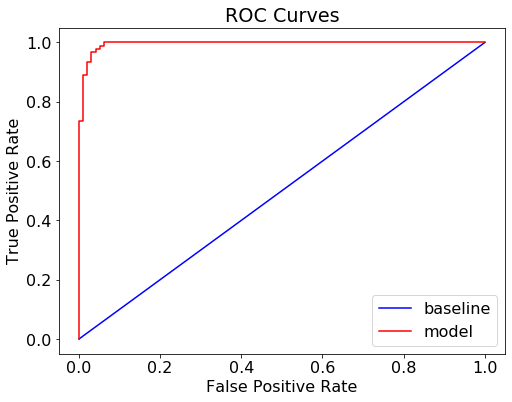

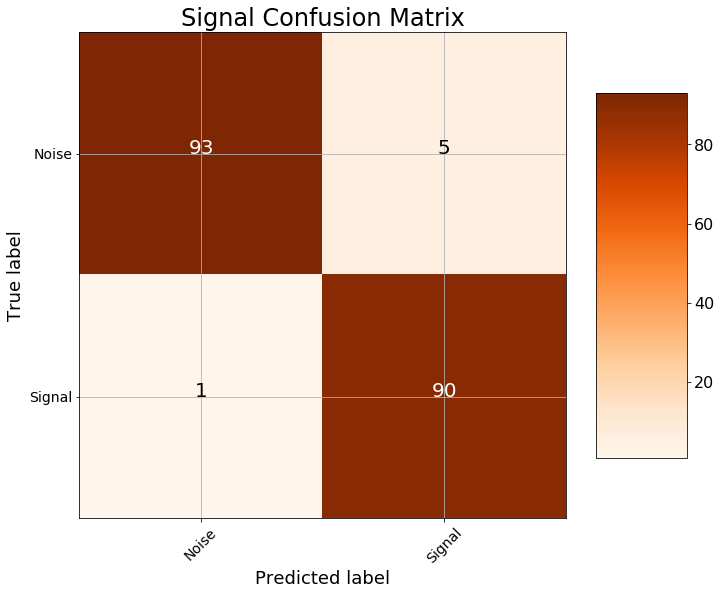

In [25]:
# 30% examples in test data 
train, test, train_labels, test_labels = train_test_split(learningDataframe.drop(columns=['Flag']), learningDataframe['Flag'], test_size=0.3, random_state=0)

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 250).astype(int),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(np.linspace(3, 30).astype(int)),
    'max_features': ['auto', 'sqrt', 'log2', None] + list(np.arange(0.5, 1, 0.01)),
    'max_leaf_nodes': [None] + list(np.linspace(1, 50, 100).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}


# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 0)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 5, 
                        n_iter = 25, verbose = 5, random_state=0)

# Fit 
rs.fit(train, train_labels)

# Finding best
best_model = rs.best_estimator_
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]
rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)

# Printing result info and graphics
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')
print(f'Best estimator is {rs.best_estimator_}')

sigp.evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs, test_labels, train_labels)
cm = sigp.confusion_matrix(test_labels, rf_predictions)
sigp.plot_confusion_matrix(cm, classes = ['Noise', 'Signal'], title = 'Signal Confusion Matrix')

In [75]:
# Summary of classification by RF
print('Random Forest Classifier\n',
      classification_report(test_labels, best_model.predict(test), target_names=['Noise', 'Signal']))

Random Forest Classifier
               precision    recall  f1-score   support

       Noise       0.99      0.95      0.97        98
      Signal       0.95      0.99      0.97        91

    accuracy                           0.97       189
   macro avg       0.97      0.97      0.97       189
weighted avg       0.97      0.97      0.97       189



In [84]:
# Now fitting the best classifier with the full learning dataset
best_model.fit(learningDataframe.drop(columns=['Flag']), learningDataframe['Flag'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=29,
                       max_features=0.5900000000000001, max_leaf_nodes=34,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=156, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

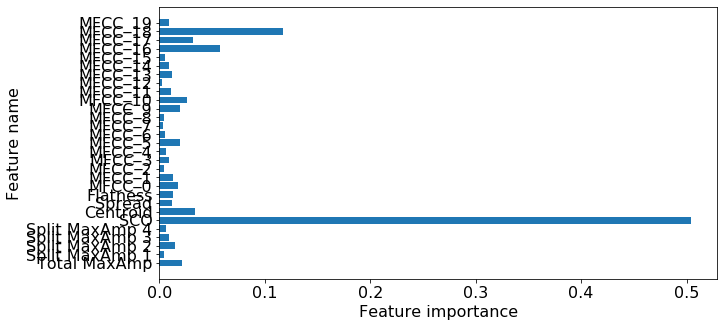

In [85]:
# Getting featurs' importance
pltut.plot_feature_importances(best_model, learningDataframe.drop(columns=['Flag']).columns)

In [86]:
# Plotting decision regions
#fig, ax = plt.subplots()
# Decision region for feature 3 = 1.5
#value = 1.5
# Plot training sample with feature 3 = 1.5 +/- 0.75
#width = 0.75

# Plotting decision regions
#fig = plot_decision_regions(train.values, train_labels.values.astype(np.integer), clf=best_model,
#              feature_index=[0,5],
#              filler_feature_values={1: value, 2: value, 3: value, 4: value, 6: value, 7: value, 8: value,
#                                    9: value, 10: value, 11: value, 12: value, 13: value, 14: value, 15: value,
#                                    16: value, 17: value, 18: value, 19: value, 20: value, 21: value, 22: value,
#                                    23: value, 24: value, 25: value, 26: value, 27: value, 28: value},  
#              filler_feature_ranges={1: width, 2: width, 3: width, 4: width, 6: width, 7: width, 8: width,
#                                    9: width, 10: width, 11: width, 12: width, 13: width, 14: width, 15: width,
#                                    16: width, 17: width, 18: width, 19: width, 20: width, 21: width, 22: width,
#                                    23: width, 24: width, 25: width, 26: width, 27: width, 28: width},
#                           legend=2, ax=ax)

# Adding axes annotations
#plt.xlabel('Total MaxAmp')
#plt.ylabel('SCO')
#plt.title('Random Forest Signal Classifier')
#plt.show()

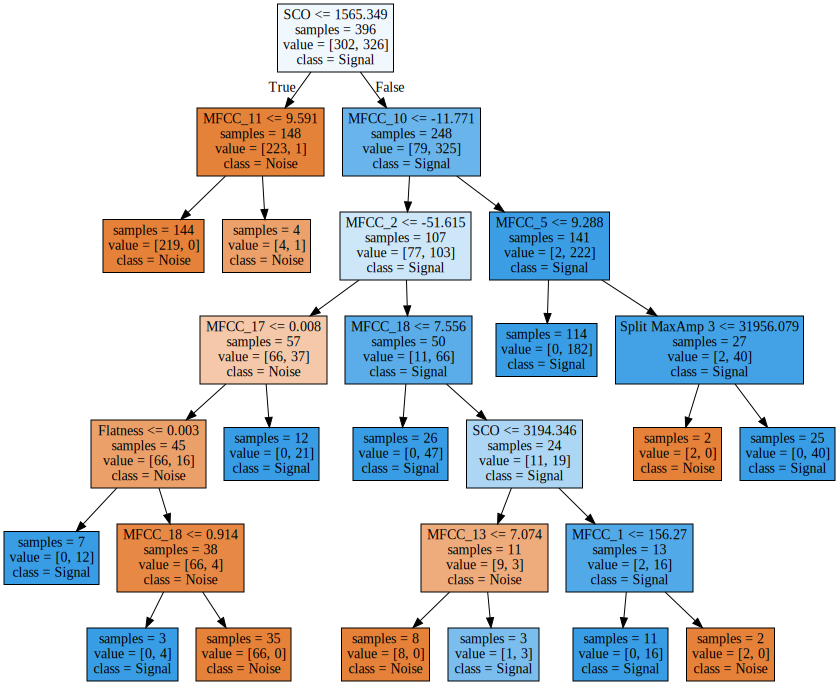

In [87]:
# Selected tree visualization
pltut.plot_decision_tree(best_model.estimators_[0], learningDataframe.drop(columns=['Flag']).columns, ['Noise', 'Signal'])

In [88]:
# Graphviz trees visualization (.estimators_[0] - first tree)
#feature_names=learningDataframe.drop(columns=['Flag']).columns
#class_names=['Noise', 'Signal']

#graph = Source(export_graphviz(best_model.estimators_[0],
#                feature_names=feature_names,
#                class_names=class_names,
#                filled=True,
#                rounded=False))
#display(SVG(graph.pipe(format='svg')))
#graph.render(filename='tree.dot', format='png')

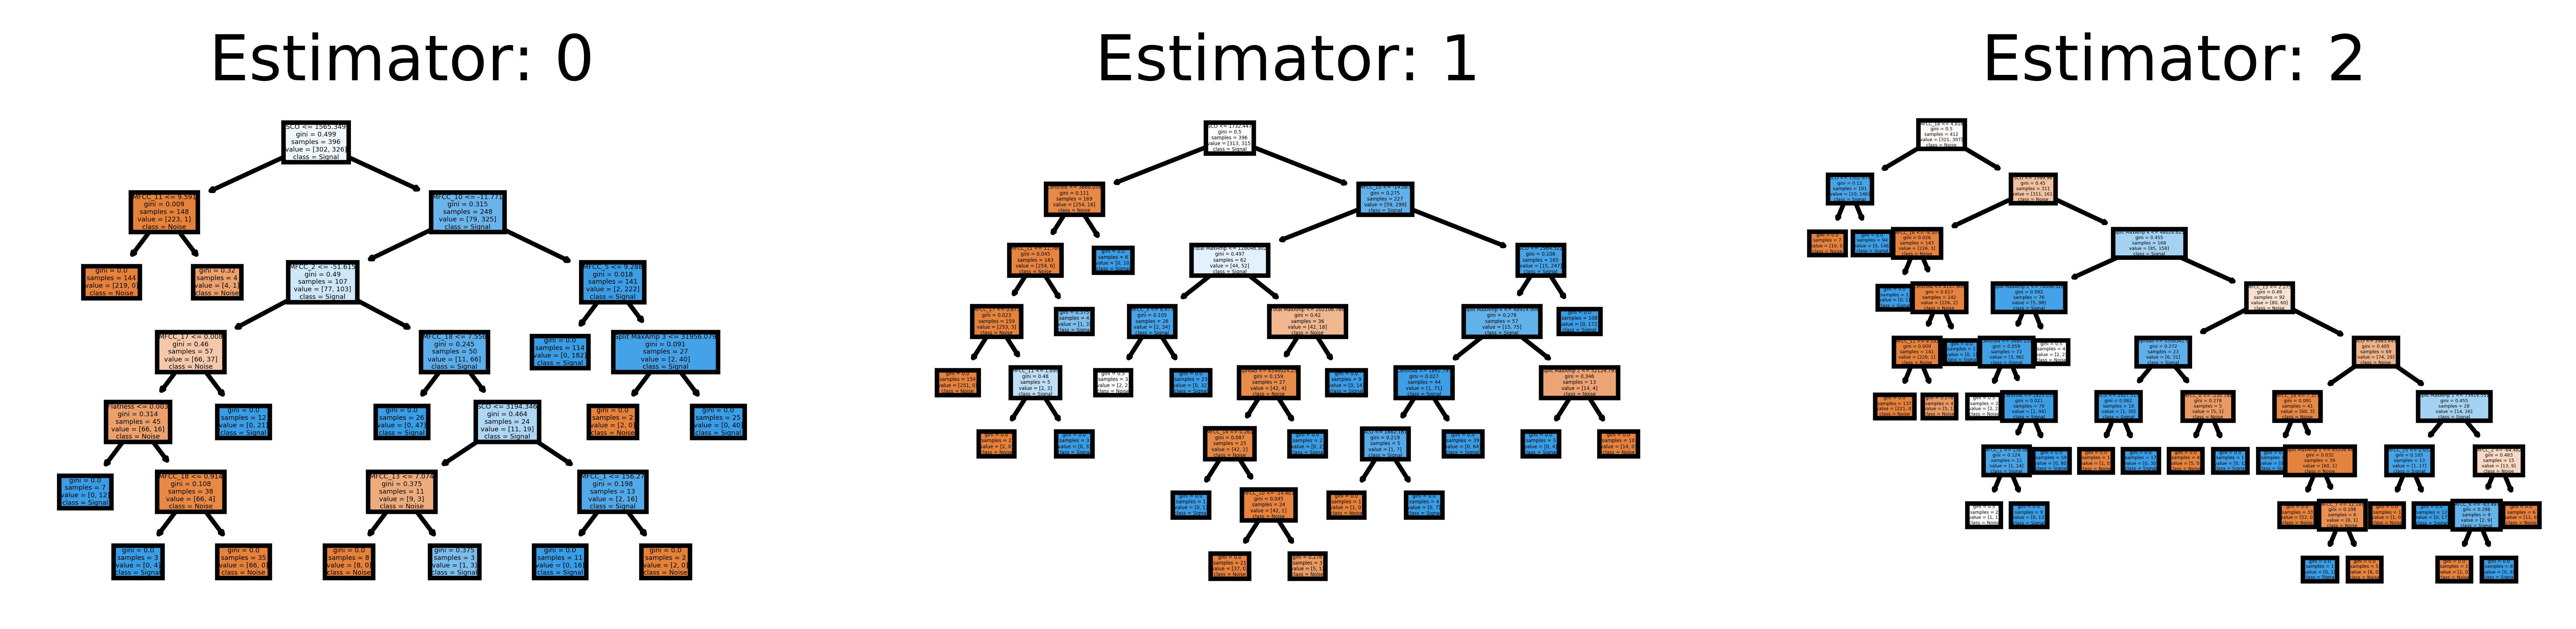

In [89]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (10,2), dpi=900)
for index in range(0, 3):
    tree.plot_tree(best_model.estimators_[index],
                   feature_names = feature_names, 
                   class_names=class_names,
                   filled = True,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 14)
fig.savefig('rf_3trees.png')

In [90]:
############################################################################## TEST ##############################################################################

In [91]:
classifierFilename = 'classificator.sav'
pickle.dump(best_model, open(classifierFilename, 'wb'))

In [92]:
# Path for packs
psignalPath = r"/home/vaclav/Desktop/Diploma/Dirty Signals/Test/Test02/"

In [93]:
# Extracting the dataframes (data characteristics)
psignalDataFrame = sigp.extract_data(psignalPath)

/home/vaclav/Desktop/Diploma/Notebooks/Classifier/signalprocessing.py:339: RuntimeWarning: divide by zero encountered in log
  return (np.exp((1 / length) * np.sum(np.log(magnitudes)))) / ((1 / length) * np.sum(magnitudes))


In [94]:
#psignalDataFrame = smfccp.pca_dataframe(psignalDataFrame, 25)
#rng = range(0, int((len(list(psignalDataFrame))-1)/2)+1)
#new_cols = ['type_' + str(i) for i in rng] + ['expt_' + str(i) for i in rng]
#psignalDataFrame.columns = new_cols[:len(list(psignalDataFrame))]

In [95]:
psignalDataFrame

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Centroid,Spread,Flatness,MFCC_0,...,MFCC_10,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19
0,136878.163007,49514.473848,50440.428752,71060.934160,85273.491169,2214.200985,2402.367925,4.769173e+06,0.003785,-256.806122,...,-14.995283,8.887760,-1.556240,7.731105,6.333805,2.864420,10.525994,-2.896785,8.410196,-6.658729
1,153366.072596,88953.620750,94829.788426,50961.478833,44580.635616,2201.611684,3126.396820,6.189995e+06,0.003666,-252.811356,...,-14.996538,6.494582,3.287429,5.020217,7.432487,-0.264453,9.383091,2.113072,6.041024,-8.057240
2,175622.764669,25518.852096,73312.362696,111797.394657,101808.648212,2222.151950,4618.439445,3.830140e+06,0.003433,-300.831268,...,-11.215708,2.460204,2.289179,1.177770,9.903216,0.452476,9.077881,4.446805,5.078933,-6.086461
3,265752.557759,131336.310868,135808.476426,126997.019200,125537.096883,3488.602739,4654.100700,6.693495e+06,0.002549,-224.165100,...,-14.191436,6.913034,10.746389,-1.752566,4.956143,5.381353,9.778929,-0.088330,7.397312,-9.252544
4,120201.005886,65412.788332,71148.483469,49956.377500,49446.458882,1690.228062,2191.467220,3.235174e+06,0.003761,-267.794067,...,-13.936343,7.424728,-0.379968,5.830671,5.478689,3.530761,9.048565,-2.490987,8.520134,-5.928402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,288320.020820,85643.467129,135419.359455,168255.587678,153588.936417,3320.122474,3614.396183,5.966329e+06,0.002696,-196.330872,...,-14.911478,9.069910,4.156929,-1.776568,11.572798,-0.988381,6.700428,0.747697,5.577942,-4.071313
496,73596.986566,8211.218710,34402.775101,42172.207262,42017.765399,1385.274610,2414.892478,1.665126e+06,0.003831,-417.939697,...,-9.098672,3.809435,1.309819,5.095041,9.629345,-0.555378,11.078399,0.042995,4.203636,-5.355798
497,228600.202381,104866.248071,149572.557800,116459.526962,27757.205927,2889.285517,4732.232034,4.874646e+06,0.002963,-273.522736,...,-7.897702,9.045395,4.017545,-2.807509,8.076990,-0.858247,9.495975,2.026670,6.133890,-6.984187
498,193593.909102,123292.096625,117398.566277,72083.070245,18625.569936,3060.940944,5356.361690,4.384689e+06,0.002793,-314.028229,...,-5.118340,-3.238841,10.836316,-1.369262,7.096030,4.253021,3.987610,-0.614972,8.691504,-6.745397


In [96]:
# Predicting the classification
predictedData = best_model.predict(psignalDataFrame)
predictedsignalDataFrame = psignalDataFrame.assign(Flag=predictedData)

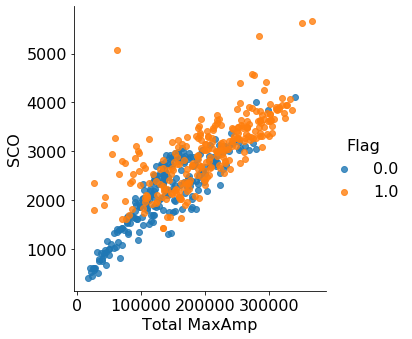

In [97]:
sn.lmplot('Total MaxAmp', 'SCO', data=predictedsignalDataFrame, hue="Flag", fit_reg=False)
#sn.lmplot('type_1', 'type_6', data=learningDataframe, hue="Flag", fit_reg=False)

In [98]:
# Loading wav files for spectrogramms
audiolist = sigp.load_list_of_wav(psignalPath)
temp = audiolist
ppredictedsignalDataFrame = predictedsignalDataFrame.loc[predictedsignalDataFrame['Flag'] == 1]
ppredictedsignalDataFrame.head()

,Total MaxAmp,Split MaxAmp 1,Split MaxAmp 2,Split MaxAmp 3,Split MaxAmp 4,SCO,Centroid,Spread,Flatness,MFCC_0,...,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,Flag
1,153366.072596,88953.620750,94829.788426,50961.478833,44580.635616,2201.611684,3126.396820,6.189995e+06,0.003666,-252.811356,...,6.494582,3.287429,5.020217,7.432487,-0.264453,9.383091,2.113072,6.041024,-8.057240,1.0
2,175622.764669,25518.852096,73312.362696,111797.394657,101808.648212,2222.151950,4618.439445,3.830140e+06,0.003433,-300.831268,...,2.460204,2.289179,1.177770,9.903216,0.452476,9.077881,4.446805,5.078933,-6.086461,1.0
3,265752.557759,131336.310868,135808.476426,126997.019200,125537.096883,3488.602739,4654.100700,6.693495e+06,0.002549,-224.165100,...,6.913034,10.746389,-1.752566,4.956143,5.381353,9.778929,-0.088330,7.397312,-9.252544,1.0
6,309957.940024,155458.825993,151349.570825,153997.438998,152229.911121,3904.096865,4776.623798,6.403331e+06,0.002415,-212.681198,...,5.024687,5.189766,2.042494,4.433432,4.693380,2.817662,0.662698,13.001268,-13.410610,1.0
8,193926.921336,19232.980921,48909.296701,123231.748582,131123.703977,2708.899064,5244.522073,5.259162e+06,0.002903,-312.029968,...,0.127948,6.409293,1.614153,5.846237,3.374866,5.516331,-1.981396,8.699478,-6.314988,1.0


No handles with labels found to put in legend.


Signal amount is  261
Signal № 1
Time resolution (s) 0.028444444444444446
Frequency resolution (Hz) 35.15625


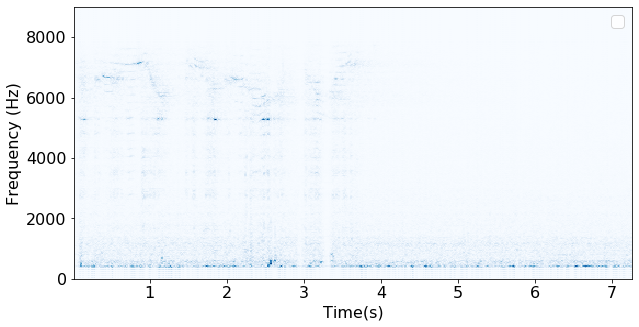

No handles with labels found to put in legend.


Signal № 2
Time resolution (s) 0.028444444444444446
Frequency resolution (Hz) 35.15625


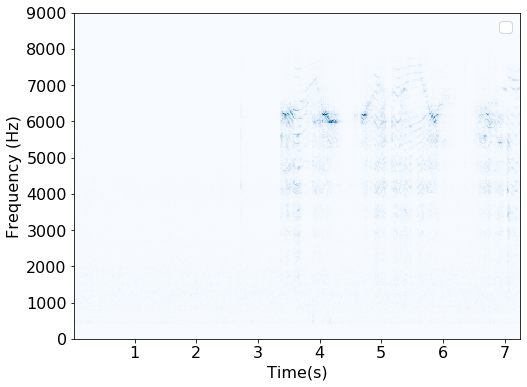

No handles with labels found to put in legend.


Signal № 3
Time resolution (s) 0.028444444444444446
Frequency resolution (Hz) 35.15625


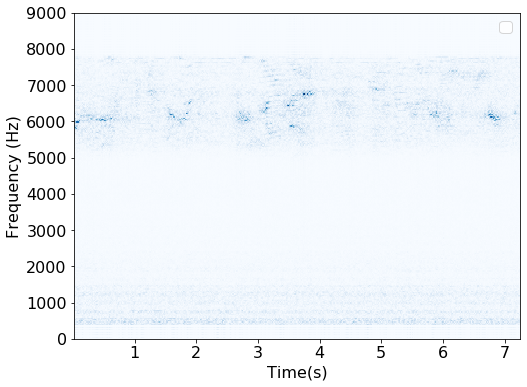

No handles with labels found to put in legend.


Signal № 6
Time resolution (s) 0.028444444444444446
Frequency resolution (Hz) 35.15625


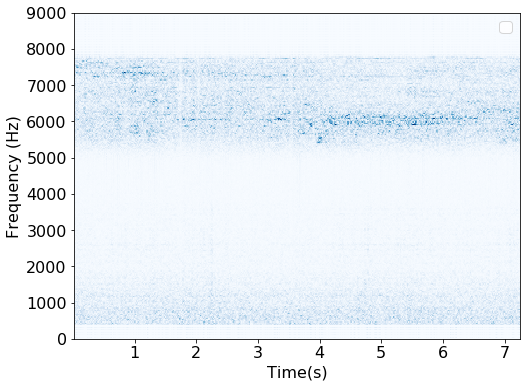

No handles with labels found to put in legend.


Signal № 8
Time resolution (s) 0.028444444444444446
Frequency resolution (Hz) 35.15625


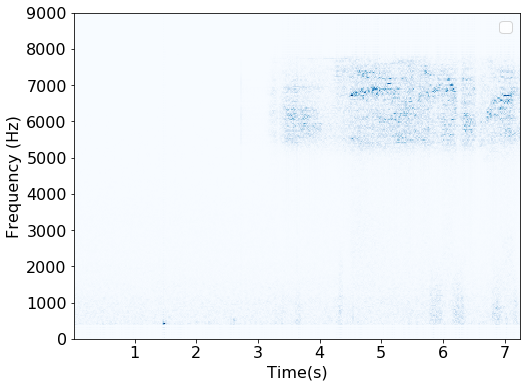

<Figure size 576x432 with 0 Axes>

In [103]:
sigp.plot_all_spectrogramms(audiolist, predictedsignalDataFrame, 512, 0, 5, 1)

In [101]:
audiolist[1].make_audio()

In [ ]:
#sigp.copy_filtered_signal(psignalPath, 45)